In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path = 'train.csv'
data = pd.read_csv(path, index_col='id', parse_dates=['date'])

In [29]:
data2 = data.loc[(data['store_nbr'] == 1) & (data['family'].isin(['MEATS', 'PERSONAL CARE'])), ['date', 'family', 'sales', 'onpromotion']]


In [30]:
dec25 = list()
for year in range(2013,2017):
    for family in ['MEATS', 'PERSONAL CARE']:
        dec18 = data2.loc[(data2['date'] == f'{year}-12-18') & (data2['family'] == family)]
        dec25 += [{'date': pd.Timestamp(f'{year}-12-25'), 'family': family, 'sales': dec18['sales'].values[0], 'onpromotion': dec18['onpromotion'].values[0]}]
data2 = pd.concat([data2, pd.DataFrame(dec25)], ignore_index=True).sort_values('date')

data2 = data2.rename(columns={'date': 'ds', 'sales': 'y', 'family': 'unique_id'})

In [31]:
data2

,ds,unique_id,y,onpromotion
0,2013-01-01,MEATS,0.000,0
1,2013-01-01,PERSONAL CARE,0.000,0
2,2013-01-02,MEATS,369.101,0
3,2013-01-02,PERSONAL CARE,194.000,0
4,2013-01-03,MEATS,272.319,0
...,...,...,...,...
3363,2017-08-13,PERSONAL CARE,45.000,5
3364,2017-08-14,MEATS,192.763,0
3365,2017-08-14,PERSONAL CARE,159.000,9
3366,2017-08-15,MEATS,274.176,0


In [32]:
train = data2.loc[data2['ds'] < '2017-01-01']
valid = data2.loc[(data2['ds'] >= '2017-01-01') & (data2['ds'] < '2017-04-01')]

In [33]:
valid

,ds,unique_id,y,onpromotion
2914,2017-01-01,MEATS,0.00000,0
2915,2017-01-01,PERSONAL CARE,0.00000,0
2916,2017-01-02,MEATS,116.72400,0
2917,2017-01-02,PERSONAL CARE,81.00000,4
2918,2017-01-03,MEATS,344.58300,0
...,...,...,...,...
3088,2017-03-29,MEATS,299.49800,1
3090,2017-03-30,MEATS,304.51300,1
3091,2017-03-30,PERSONAL CARE,108.00000,6
3093,2017-03-31,PERSONAL CARE,137.00000,3


In [34]:
train['unique_id'].value_counts()

MEATS            1461
PERSONAL CARE    1461
Name: unique_id, dtype: int64

In [35]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

models = [RandomForestRegressor(random_state=0, n_estimators=100),
          ExtraTreesRegressor(random_state=0, n_estimators=100)]

In [36]:
from numba import njit

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

In [38]:
from window_ops.rolling import rolling_mean
from mlforecast import MLForecast

model = MLForecast(models=models,
                   freq='D',
                   lags=[1,7,14],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_mean, 7), (rolling_mean, 28), (diff, 1), (diff, 7)],
                   },
                   date_features=['dayofweek'],
                   num_threads=6)

In [39]:
train

,ds,unique_id,y,onpromotion
0,2013-01-01,MEATS,0.000,0
1,2013-01-01,PERSONAL CARE,0.000,0
2,2013-01-02,MEATS,369.101,0
3,2013-01-02,PERSONAL CARE,194.000,0
4,2013-01-03,MEATS,272.319,0
...,...,...,...,...
2908,2016-12-29,MEATS,234.882,1
2910,2016-12-30,MEATS,616.282,46
2911,2016-12-30,PERSONAL CARE,154.000,6
2913,2016-12-31,PERSONAL CARE,150.000,7


In [40]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

MLForecast(models=[RandomForestRegressor, ExtraTreesRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag14', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size7', 'rolling_mean_lag1_window_size28', 'diff_lag1_lag1', 'diff_lag1_lag7'], date_features=['dayofweek'], num_threads=6)

In [44]:
valid

,ds,unique_id,y,onpromotion
2914,2017-01-01,MEATS,0.00000,0
2915,2017-01-01,PERSONAL CARE,0.00000,0
2916,2017-01-02,MEATS,116.72400,0
2917,2017-01-02,PERSONAL CARE,81.00000,4
2918,2017-01-03,MEATS,344.58300,0
...,...,...,...,...
3088,2017-03-29,MEATS,299.49800,1
3090,2017-03-30,MEATS,304.51300,1
3091,2017-03-30,PERSONAL CARE,108.00000,6
3093,2017-03-31,PERSONAL CARE,137.00000,3


In [41]:
p = model.predict(horizon=90, dynamic_dfs=[valid[['unique_id', 'ds', 'onpromotion']]])

In [42]:
p

,unique_id,ds,RandomForestRegressor,ExtraTreesRegressor
0,MEATS,2017-01-01,149.994890,113.505970
1,MEATS,2017-01-02,248.270500,265.383180
2,MEATS,2017-01-03,278.254560,274.265770
3,MEATS,2017-01-04,274.139078,261.437127
4,MEATS,2017-01-05,267.360940,237.657200
...,...,...,...,...
175,PERSONAL CARE,2017-03-27,164.840000,151.400000
176,PERSONAL CARE,2017-03-28,166.290000,148.220000
177,PERSONAL CARE,2017-03-29,162.400000,159.110000
178,PERSONAL CARE,2017-03-30,158.428140,142.490000


In [ ]:
p = p.merge(valid[['unique_id', 'ds', 'y']], on=['unique_id', 'ds'], how='left')

In [17]:
p['unique_id'].value_counts()

MEATS            90
PERSONAL CARE    90
Name: unique_id, dtype: int64

In [20]:
model.fit(train, id_col='unique_id', time_col='ds', target_col='y',
            static_features=[], max_horizon=90)

MLForecast(models=[RandomForestRegressor, ExtraTreesRegressor], freq=<Day>, lag_features=['lag1', 'lag7', 'lag14', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size7', 'rolling_mean_lag1_window_size28', 'diff_lag1_lag1', 'diff_lag1_lag7'], date_features=['dayofweek'], num_threads=6)

In [21]:
pd.Series(model.models_['RandomForestRegressor'].feature_importances_, index=model.ts.features_order_).sort_values(ascending=False).plot.bar(
            figsize=(1280/96,720/96), title='RandomForestRegressor Feature Importance', xlabel='Features', ylabel='Importance')

AttributeError: 'list' object has no attribute 'feature_importances_'

In [22]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

print(f"WMAPE RandomForestRegressor: {wmape(p['y'], p['RandomForestRegressor'])}\nWMAPE ExtraTreesRegressor: {wmape(p['y'], p['ExtraTreesRegressor'])}")

WMAPE RandomForestRegressor: 0.18781740494466106
WMAPE ExtraTreesRegressor: 0.179807841911756


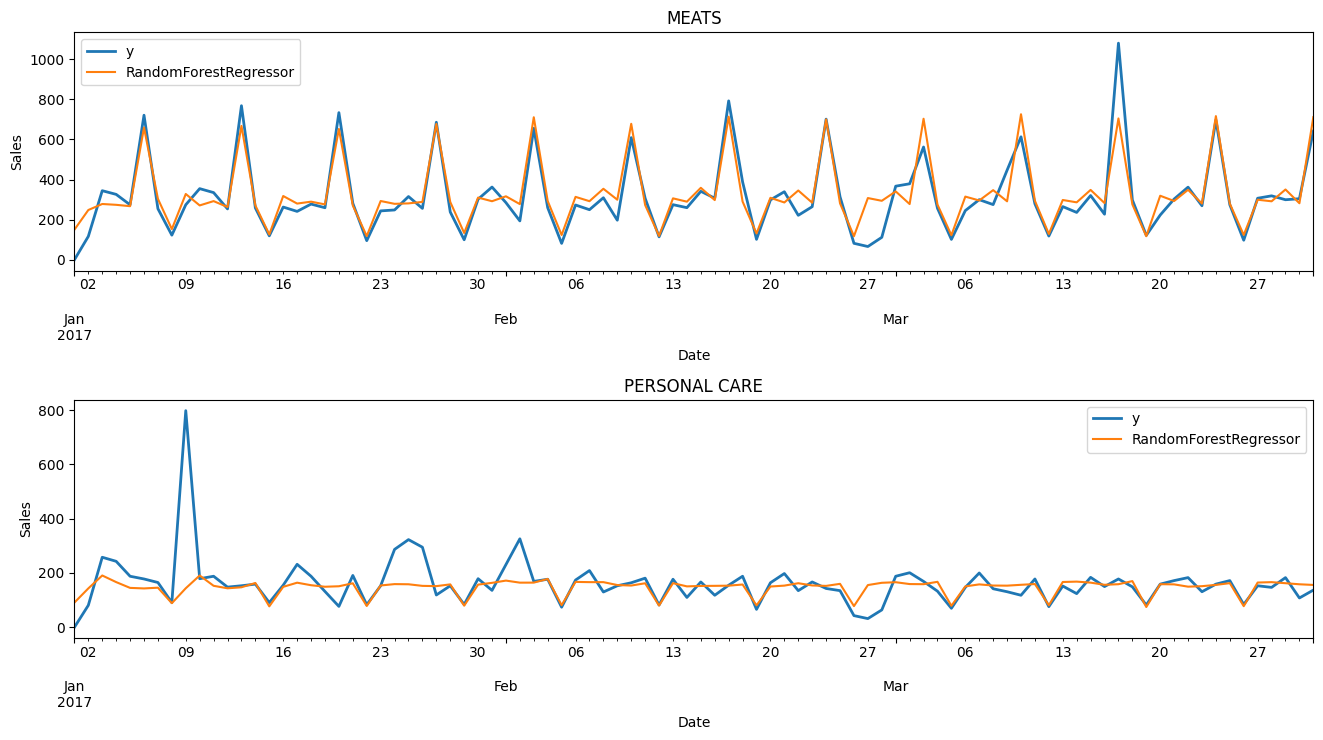

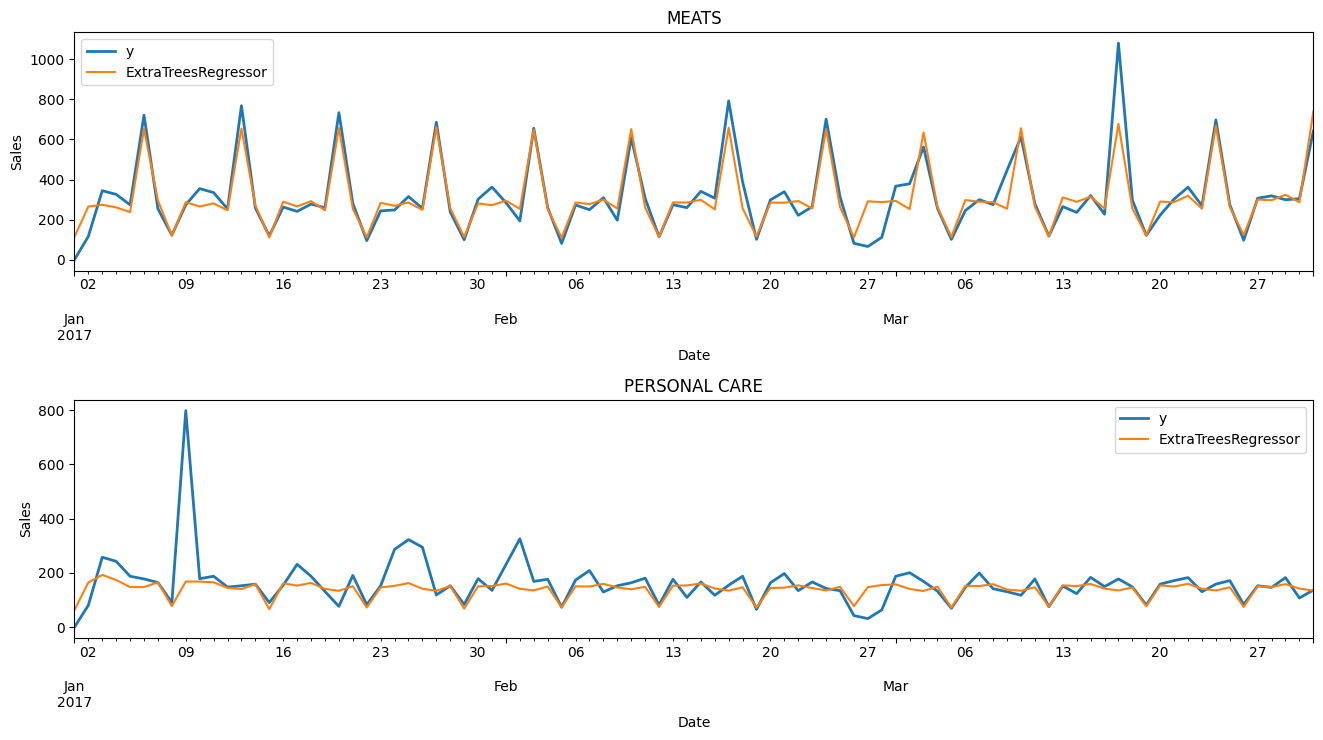

In [23]:
for model in ['RandomForestRegressor', 'ExtraTreesRegressor']:
    fig,ax = plt.subplots(2,1, figsize=(1280/96, 720/96))
    for ax_, family in enumerate(['MEATS', 'PERSONAL CARE']):
        p.loc[p['unique_id'] == family].plot(x='ds', y='y', ax=ax[ax_], label='y', title=family, linewidth=2)
        p.loc[p['unique_id'] == family].plot(x='ds', y=model, ax=ax[ax_], label=model)
        ax[ax_].set_xlabel('Date')
        ax[ax_].set_ylabel('Sales')
        fig.tight_layout()

In [45]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

print(f"WMAPE RandomForestRegressor: {wmape(p['y'], p['RandomForestRegressor'])}\nWMAPE ExtraTreesRegressor: {wmape(p['y'], p['ExtraTreesRegressor'])}")

KeyError: 'y'

### Resource
- [Multiple Time Series Forecasting With Scikit-learn](https://forecastegy.com/posts/multiple-time-series-forecasting-with-scikit-learn/#feature-engineering-for-time-series-forecasting)
- [Multiple Time Series Forecasting With XGBoost In Python](https://forecastegy.com/posts/multiple-time-series-forecasting-with-xgboost-in-python/#how-to-install-xgboost-and-mlforecast)